In [1]:
import json

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.transforms import v2

from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
import masks
from exp_base import get_accuracy, train, plot_probs, init_image

In [3]:
output = {
    "num_classes": [],
    "acc": [],
    "probs": [],
    "epochs": []
}

### Visual check

Files already downloaded and verified
[]
[(6, 14)]
[(6, 14), (5, 13)]
[(6, 14), (5, 13), (24, 23)]
[(6, 14), (5, 13), (24, 23), (23, 31)]
[(6, 14), (5, 13), (24, 23), (23, 31), (18, 27)]
[(6, 14), (5, 13), (24, 23), (23, 31), (18, 27), (28, 19)]
[(6, 14), (5, 13), (24, 23), (23, 31), (18, 27), (28, 19), (30, 14)]
[(6, 14), (5, 13), (24, 23), (23, 31), (18, 27), (28, 19), (30, 14), (18, 1)]
[(6, 14), (5, 13), (24, 23), (23, 31), (18, 27), (28, 19), (30, 14), (18, 1), (17, 29)]
[(6, 14), (5, 13), (24, 23), (23, 31), (18, 27), (28, 19), (30, 14), (18, 1), (17, 29), (30, 29)]
[(6, 14), (5, 13), (24, 23), (23, 31), (18, 27), (28, 19), (30, 14), (18, 1), (17, 29), (30, 29), (29, 31)]
[(6, 14), (5, 13), (24, 23), (23, 31), (18, 27), (28, 19), (30, 14), (18, 1), (17, 29), (30, 29), (29, 31), (18, 17)]
[(6, 14), (5, 13), (24, 23), (23, 31), (18, 27), (28, 19), (30, 14), (18, 1), (17, 29), (30, 29), (29, 31), (18, 17), (31, 5)]
[(6, 14), (5, 13), (24, 23), (23, 31), (18, 27), (28, 19), (30, 14),

Text(0.5, 1.0, 'With hidden random pixels')

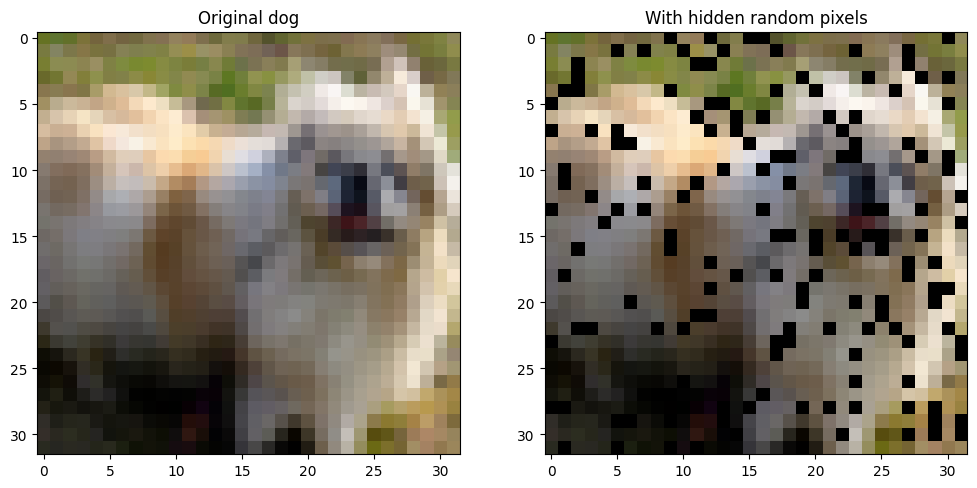

In [9]:
from torchvision import transforms, datasets
from matplotlib import pyplot as plt


trainset = datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transforms.ToTensor())
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


index = 40
test_image = trainset[index][0]
label = trainset[index][1]
f, axs = plt.subplots(1,2, figsize=(12, 8))
axs[0].imshow(test_image.permute(1, 2, 0))
axs[0].set_title(f"Original {classes[label]}")
# axs[1].imshow(mask_part(test_image.unsqueeze(0), label, 10).squeeze().permute(1, 2, 0))
axs[1].imshow(masks.MaskRandomPixels(10, 32, device=torch.device("cpu"))(test_image, 0).permute(1, 2, 0).detach().numpy())
axs[1].set_title(f"With hidden random pixels")


In [4]:
def get_accuracy_random_mask(model, univ_image, num_classes, mask):
    """
        Validating method
        returns count of correct predictions and their probabilities
    """

    with torch.no_grad():
        probs = []
        k = 0
        for label in range(num_classes):
            masked = mask(univ_image, label).unsqueeze(0)
            preds = model(norm(masked))
            after_softmax = torch.nn.Softmax(dim=1)(preds)
            # print("after_softmax:", after_softmax)
            prob, pred_label = torch.nn.Softmax(dim=1)(preds).max(1)
            if pred_label[0] == label:
                k += 1
            # prob_list = [float(x) for x in prob[0].cpu().detach().numpy()]
            probs.append(prob[0].item())

        return k, probs

In [5]:
from datetime import datetime

norm = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def train_mask_random(model, univ_image, epochs, batch_size, num_classes, criterion, mask, writer=None) -> tuple[torch.Tensor, int]:
    """
        Train method. Returns configured univ_image
    """
    opt = optim.SGD([univ_image], lr=1e-1)
    # criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.3, patience=250, min_lr=1e-4, threshold=1e-4)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    cur_class = 0
    start_time = datetime.now()
    for t in range(epochs):

        batch = []
        labels = []
        for k in range(batch_size):
            batch.append(mask(univ_image, cur_class).to(device))
            labels.append(cur_class)
            cur_class = (cur_class + 1) % num_classes
        batch = torch.stack(batch, dim=0).to(device)
        labels = torch.LongTensor(labels).to(device)

        preds = model(norm(batch))
        loss = criterion(preds, labels)

        opt.zero_grad()
        loss.backward()
        opt.step()

        scheduler.step(loss.item())

        univ_image.data.clamp_(0, 1)

        acc, probs = get_accuracy_random_mask(model, univ_image, num_classes, mask)
        # print('probs:', probs)
        if t % (epochs // 10) == 0:
            # print(preds.shape, labels.shape)

            delta = datetime.now() - start_time
            start_time = datetime.now()

            print(
                f"EPOCH = {t}/{epochs} | loss = {loss.item()} | acc={acc / num_classes} | lr={scheduler.optimizer.param_groups[0]['lr']} | time={int(delta.total_seconds() // 60)}:{delta.seconds % 60}")
            if writer is not None:
                writer.add_scalar(f'Acc', acc / num_classes, t)

        if writer is not None:
            writer.add_scalar(f'Loss', loss.item(), t)
            writer.add_scalar(f'LR', scheduler.optimizer.param_groups[0]['lr'], t)
            writer.flush()

        if acc == num_classes:
            print(
                f"CLOSING EPOCH = {t}/{epochs} | loss = {loss.item()} | acc={acc / num_classes} | lr={scheduler.optimizer.param_groups[0]['lr']} | time={int(delta.total_seconds() // 60)}:{delta.seconds % 60}")
            return univ_image, t

    return univ_image, epochs


In [6]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

NUM_CLASSES = range(2, 65, 4)
BATCH_SIZE = 64  
IMAGE_SIZE = 64
EPOCHS = 5000
# CRITERION = FocalLoss(gamma=1) 
CRITERION = nn.CrossEntropyLoss()

# writer = SummaryWriter(f"runs/experiment 1", comment=f"{BATCH_SIZE=}\n{IMAGE_SIZE=}\n{EPOCHS=}\n{MASK.__name__=}\n{CRITERION.__class__.__name__=}")
print(f"Running experiment 3")

for num_classes in NUM_CLASSES:
    MASK = masks.MaskRandomPixels(num_classes, IMAGE_SIZE, device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))
    univ_image = init_image(IMAGE_SIZE)
    
    print(f"---------- num_classes={num_classes} ----------")
    
    # model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    # model.fc = nn.Linear(in_features=2048, out_features=num_classes)
    # nn.init.xavier_uniform_(model.fc.weight)
    # model.fc.bias.data.fill_(0.01)
    univ_image, epochs = train_mask_random(
        model=model,
        univ_image=univ_image,
        epochs=EPOCHS,
        batch_size=num_classes,
        num_classes=num_classes,
        criterion=CRITERION,
        mask=MASK,
        writer=None
    )
    
    acc, probs = get_accuracy_random_mask(model, univ_image, num_classes, MASK)
    # print(probs)
    
    output["num_classes"].append(num_classes)
    output["acc"].append(acc /  num_classes)
    output["probs"].append(probs)
    output["epochs"].append(epochs)

with open("result.json", "w") as f:
    json.dump(output, f)

Running experiment 3
---------- num_classes=2 ----------
EPOCH = 0/5000 | loss = 11.960376739501953 | acc=0.0 | lr=0.1 | time=0:0
CLOSING EPOCH = 69/5000 | loss = 1.6832170486450195 | acc=1.0 | lr=0.1 | time=0:0
---------- num_classes=6 ----------
EPOCH = 0/5000 | loss = 12.335284233093262 | acc=0.0 | lr=0.1 | time=0:0
CLOSING EPOCH = 267/5000 | loss = 0.6199114918708801 | acc=1.0 | lr=0.1 | time=0:0
---------- num_classes=10 ----------
EPOCH = 0/5000 | loss = 16.169153213500977 | acc=0.0 | lr=0.1 | time=0:0
CLOSING EPOCH = 374/5000 | loss = 0.48995766043663025 | acc=1.0 | lr=0.1 | time=0:0
---------- num_classes=14 ----------
EPOCH = 0/5000 | loss = 12.358291625976562 | acc=0.0 | lr=0.1 | time=0:0
EPOCH = 500/5000 | loss = 0.6962900161743164 | acc=0.9285714285714286 | lr=0.1 | time=1:7
CLOSING EPOCH = 677/5000 | loss = 0.4876345098018646 | acc=1.0 | lr=0.1 | time=1:7
---------- num_classes=18 ----------
EPOCH = 0/5000 | loss = 13.756976127624512 | acc=0.0 | lr=0.1 | time=0:0
EPOCH = 5

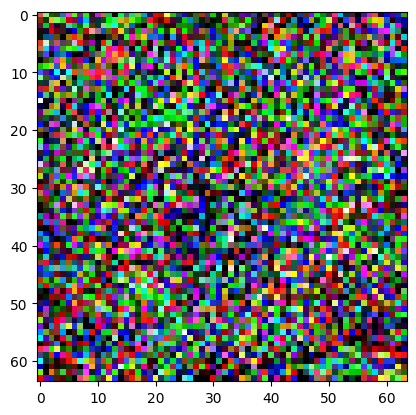

In [9]:
import matplotlib.pyplot as plt

plt.imshow((univ_image.permute(1, 2, 0).cpu().detach().numpy() * 255).astype(np.uint8))
plt.savefig("./image_random_mask.png")

In [10]:
print(output["epochs"])

[69, 267, 374, 677, 773, 1118, 1271, 1768, 2910, 2263, 1760, 5000, 2586, 5000, 5000, 5000]


In [11]:
output["num_classes"]

[2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62]

In [68]:
with open("result.json", "w") as f:
    json.dump(output["probs"], f)

TypeError: Object of type ndarray is not JSON serializable

In [71]:
output["probs"][0]

[array([0.05812764], dtype=float32), array([0.16368069], dtype=float32)]